# 単層ニューラルネットによる二項分類

うまくいかない時はKernelをReconnectする

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

np.random.seed(2016)
tf.set_random_seed(42)

def generate_datablock(n, mu, var, t): #生成個数, 平均座標mu[x1,x2], 分散, tはラベル
    data = multivariate_normal(mu, np.eye(2)*var, n)#分散共分散行列[[10,0],[0,10]],np.eye()は2次元の単位行列を生成している
    df = DataFrame(data, columns=['x1', 'x2'])
    df['t'] = t
    return df


df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7, 22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)#データの中身をある方向にそのままつなげるpd.concat　列方向(縦)に連結
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)#より本物のデータらしくするために行の順番を入れ替えている

In [30]:
df

,x1,x2,t
0,8.382988,9.382908,0
1,10.305525,10.874896,0
2,17.016158,4.336603,0
3,10.448555,2.450318,0
4,10.256256,13.432117,0
5,-0.042854,9.188072,0
6,13.954796,15.117742,0
7,3.226998,-3.012046,0
8,4.658246,6.753437,0
9,5.115962,5.052748,0


### 可視化してみる

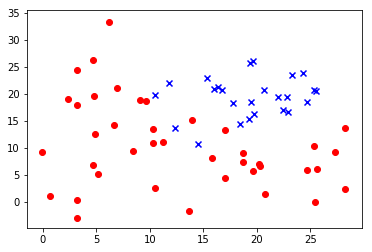

In [31]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
subplot.scatter(df0['x1'], df0['x2'], color='r',marker='o')
subplot.scatter(df1['x1'], df1['x2'], color='r',marker='o')
subplot.scatter(df2['x1'], df2['x2'], color='r',marker='o')
subplot.scatter(df3['x1'], df3['x2'], color='b',marker='x')
plt.show()

In [32]:
train_x = train_set[['x1','x2']].values #.as_matrix()　は非推奨で .valuesに置き換える
train_t = train_set['t'].values.reshape([len(train_set), 1]) #[1,1,1,...,1]のようになっているので縦に置き換える。

In [33]:
num_units = 4
mult = train_x.flatten().mean()#全てのx1,x2の平均値

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))#truncated_normalは乱数を用いて初期値を決定している
#指定サイズの多次元リストに対応するVariableを用意して、それぞれの要素を平均0標準偏差1の正規分布の乱数を初期化する
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1*mult)#平均値をかけることでパラメーターの最適化処理を高速化する
#内容は4.2のパーセプトロンの幾何学的な解釈を参照

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)#t=1である確率Pnを並べた行列になる

In [34]:
t = tf.placeholder(tf.float32, [None, 1])
loss = - tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.0005).minimize(loss)#勾配降下方のアルゴリズムを愚直に適用するシンプルなトレーニングアルゴリズムで
#学習率εの値を明示的に指定する、　ここでの学習率ε=0.001は試行錯誤の末決定したもの
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5)) #y = sign(x) = -1 if x < 0;     0 if x == 0;      1 if x > 0.  equalはFalse,Trueを返す
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #tf.cast( 変換したいもの , 変換後の型 ) castでFalseを0,Trueを1に変換するので正答率と一致する

In [35]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [36]:
i = 0
for _ in range(4000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 ==0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
        print('Step: %d, Loss: %f, Accuracy: %f' % (i, loss_val, acc_val))

Step: 100, Loss: 9.987391, Accuracy: 0.923077
Step: 200, Loss: 8.809364, Accuracy: 0.923077
Step: 300, Loss: 8.445268, Accuracy: 0.923077
Step: 400, Loss: 8.276822, Accuracy: 0.923077
Step: 500, Loss: 8.175752, Accuracy: 0.923077
Step: 600, Loss: 8.105235, Accuracy: 0.923077
Step: 700, Loss: 8.051959, Accuracy: 0.923077
Step: 800, Loss: 8.009809, Accuracy: 0.923077
Step: 900, Loss: 7.975616, Accuracy: 0.923077
Step: 1000, Loss: 7.947499, Accuracy: 0.923077
Step: 1100, Loss: 7.924205, Accuracy: 0.923077
Step: 1200, Loss: 7.904808, Accuracy: 0.923077
Step: 1300, Loss: 7.888607, Accuracy: 0.923077
Step: 1400, Loss: 7.875025, Accuracy: 0.923077
Step: 1500, Loss: 7.863523, Accuracy: 0.923077
Step: 1600, Loss: 7.853851, Accuracy: 0.923077
Step: 1700, Loss: 7.845700, Accuracy: 0.923077
Step: 1800, Loss: 7.839014, Accuracy: 0.923077
Step: 1900, Loss: 7.833384, Accuracy: 0.923077
Step: 2000, Loss: 7.828625, Accuracy: 0.923077
Step: 2100, Loss: 7.824596, Accuracy: 0.923077
Step: 2200, Loss: 7.82

### 可視化

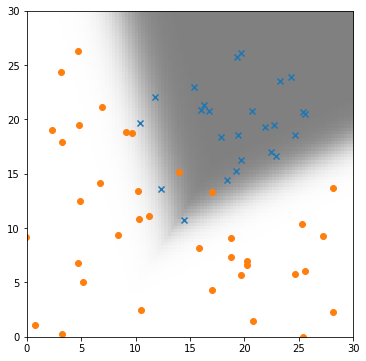

In [37]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2 , marker = 'x')
subplot.scatter(train_set2.x1, train_set2.x2, marker = 'o')

locations = []
for x2 in np.linspace(0, 30 , 100):
    for x1 in np.linspace(0, 30, 100):
        locations.append((x1, x2))
p_vals = sess.run(p, feed_dict= {x:locations})
p_vals = p_vals.reshape((100, 100))

subplot.imshow(p_vals, origin = 'lower', extent = (0, 30, 0, 30), cmap = plt.cm.gray_r, alpha = 0.5)
#extentは、座標に振るメモリの範囲を左下を原点にして、(xmin,xmax,ymin,ymax)で指定します。
#origin は配列の[0][0]を左下、左上どちらから開始するかを示す。lowerは下から
plt.show()

ノードを増やしたので誤差関数の形状はより複雑になったと想像できるので、学習率εを小さくし、より細かく、なんども修正する必要がある。
原理的にはノードが4つなので4本の直線で分割されるが、範囲外のところに存在し、データ分類には寄与しないものもある。
このように隠れ層のノードを増やすことで、より複雑なデータ配置に対応することが可能になる。